# Melanoma Detection Assignment

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
# Mounting the google drive :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


- This assignment uses a dataset of about 2357 images of skin cancer types.
- The dataset contains 9 sub-directories in each train and test subdirectories.
- The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:

image_count_train = len(list(data_dir_train.glob('*/*.jpg'))) #.glob() method used to find files/directories that match the pattern
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,          # path to the directory with images
    seed=123,                # for reproducibility
    validation_split=0.2,    # 80% training, 20% validation
    subset='training',       # loading the training set
    image_size=(img_height, img_width),  # resize all images to 180x180 pixels
    batch_size=batch_size)           # load 32 images per batch

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',   # loading the validation set
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:

# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

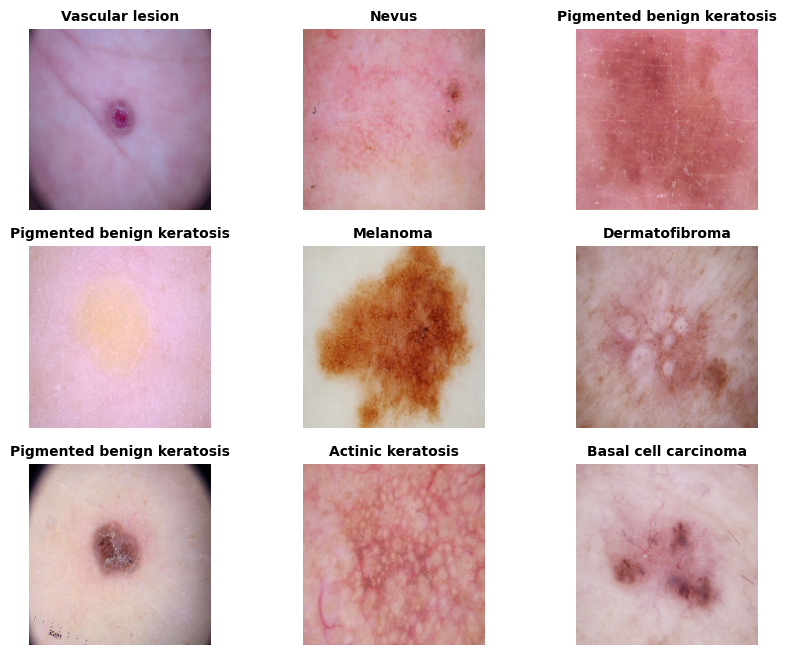

In [10]:
### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]].capitalize(),fontsize=10, fontweight='bold')
        plt.axis("off")

Insights: The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [11]:
# cache() keeps the images in memory after they're loaded off disk during the first epoch.
# prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

** Model Building & training: **
#### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset

In [12]:
### Your code goes here

num_classes = 9 # Define the number of classes
model = Sequential([ # Create a Sequential model
    layers.Rescaling(1./255, input_shape=(img_height, img_width,3)) # Rescale pixel values to the range [0,1]
])
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(180, 180, 32))) #Add a convolutional layer
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'))# Add another convolutional layer
model.add(MaxPool2D(pool_size=(2,2)))# Add a max pooling layer

# Add another convolutional layer with max pooling layers, gradually increasing the number of filters
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25)) # Add a dropout layer with a dropout rate of 25%
model.add(Flatten()) # Flatten the output from the convolutional layers
model.add(Dense(num_classes, activation='softmax')) # Add a fully connected dense layer with softmax activation for classification

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
model.compile(optimizer='adam',               # Widely used optimizer
              loss='sparse_categorical_crossentropy', # Suitable for multi-class classification
              metrics=['accuracy'])            # It's a common metric for classification

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 180, 180, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 90, 90, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 45, 45, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 22, 22, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7744)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 9)                   │          69,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,129 (1.06 MB)

 Trainable params: 277,129 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
epochs = 20
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    verbose=1)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 241s 936ms/step - accuracy: 0.1854 - loss: 2.0950 - val_accuracy: 0.2908 - val_loss: 1.9864
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.2555 - loss: 1.9627 - val_accuracy: 0.3647 - val_loss: 1.7720
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.2778 - loss: 1.9106 - val_accuracy: 0.3110 - val_loss: 1.8395
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.3600 - loss: 1.7804 - val_accuracy: 0.4027 - val_loss: 1.6375
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.4011 - loss: 1.6762 - val_accuracy: 0.4228 - val_loss: 1.7080
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.4213 - loss: 1.6219 - val_accuracy: 0.4653 - val_loss: 1.5286
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.4641 - loss: 1.5036 - val_accuracy: 0.4497 - val_loss: 1.5453
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.4841 - loss: 1.4577 - val_accuracy: 0.4519 

### Visualizing training results

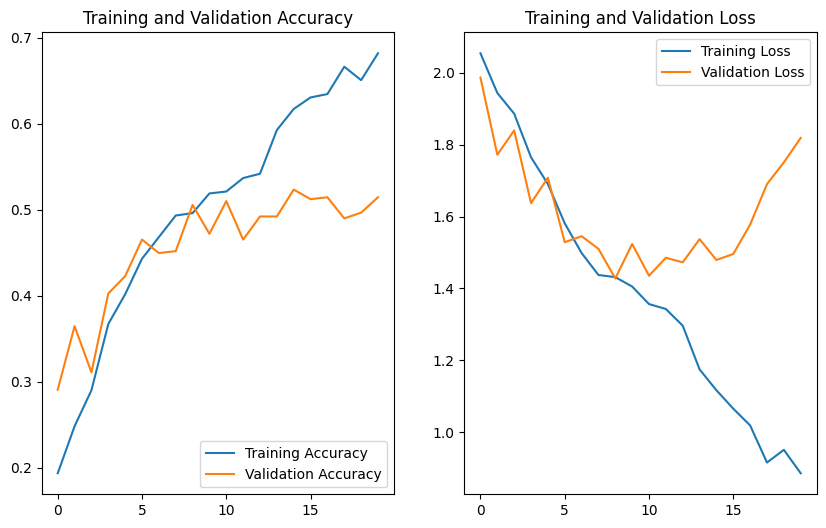

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) #define range of numbers from 0 to epochs - 1

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

acuracy graph:
- there is significant gap between the trainning and validation accuracy from aroung 10 epoch onward. the traning accuracy continues to improve steadily where validation. accuracy not showing much improvement.
- training accuracy reached 0.6 by the end whereas the validation accuracy near to 0.4.

loss graph:
- after 10 epoch the training loss decreases but validation loss begin to increase. it's sign of overfitting

so the model is overfitting after about 10 epochs. we need to use some techniques to reduce overfit

In [17]:
# After you have analysed the model fit overfit, choose an appropriate data augumentation strategy.
# Your code goes here

# Define a Sequential model for data augmentation
augmentation_data = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),  # Randomly flip images
    layers.RandomRotation(0.2),  # Randomly rotate images
    layers.RandomZoom(0.1),  # Randomly zoom into images
])


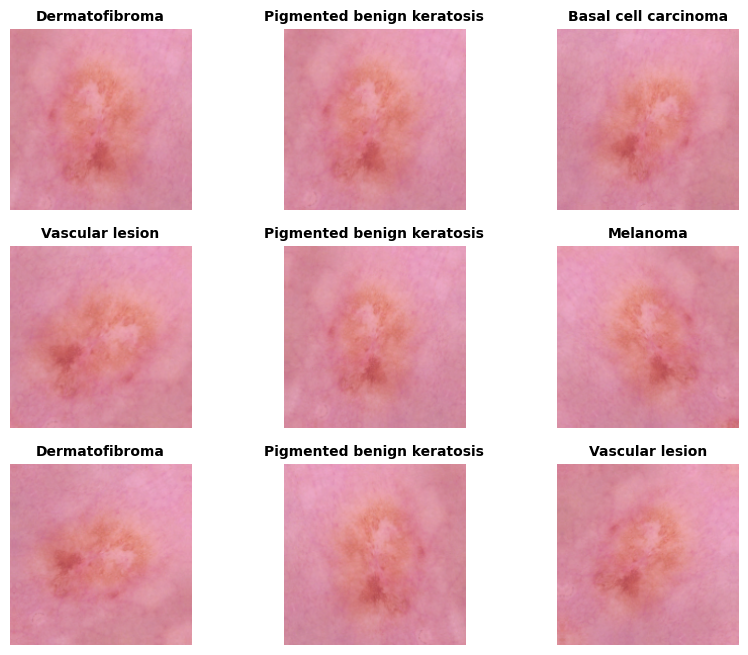

In [18]:
# Visualize how your augmentation strategy works for one instance of training image.
# Your code goes here


plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[i]].capitalize(),fontsize=10, fontweight='bold')
        plt.axis("off")

In [19]:
### Todo:
### Create the second model, compile and train the model

num_classes = 9 # Define the number of classes

model = Sequential([ # Create a Sequential model
    augmentation_data,  # Apply data augmentation strategy
    layers.Rescaling(1./255, input_shape=(img_height, img_width,3))     # Rescale pixel values to the range [0,1]
])

# Add convolutional layers to extract features from the input images
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(180, 180, 32)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25)) # Add Dropout layer to mitigate overfitting
model.add(Flatten()) # Flatten the output from convolutional layers
model.add(Dense(num_classes, activation='softmax')) # Add a fully connected dense layer with softmax activation for classification

### Compiling the model

In [20]:
## Your code goes here

model.compile(
    optimizer='adam',  # Use the Adam optimizer for training
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Use Sparse Categorical Crossentropy loss function
    metrics=['accuracy']  # Track accuracy metric during training
)

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
# Train the model for 20 epochs using the training dataset and validate it using the validation dataset

# Set the number of epochs for training
epochs = 20

# Train the model using the training dataset and validate it using the validation dataset
history = model.fit(
    train_ds,          # Training dataset
    validation_data=val_ds,   # Validation dataset
    epochs=epochs      # Number of epochs for training
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.1666 - loss: 2.1155 - val_accuracy: 0.2058 - val_loss: 2.0194
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.2328 - loss: 2.0226 - val_accuracy: 0.2886 - val_loss: 1.9184
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.2779 - loss: 1.9271 - val_accuracy: 0.3266 - val_loss: 1.8150
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.3210 - loss: 1.8012 - val_accuracy: 0.3915 - val_loss: 1.6816
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.3392 - loss: 1.7629 - val_accuracy: 0.4072 - val_loss: 1.5897
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.3949 - loss: 1.6267 - val_accuracy: 0.4228 - val_loss: 1.6302
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.4286 - loss: 1.5678 - val_accuracy: 0.3781 - val_loss: 1.6332
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.3951 - loss: 1.5830 - val_accuracy: 0.4877 -

### Visualizing the results

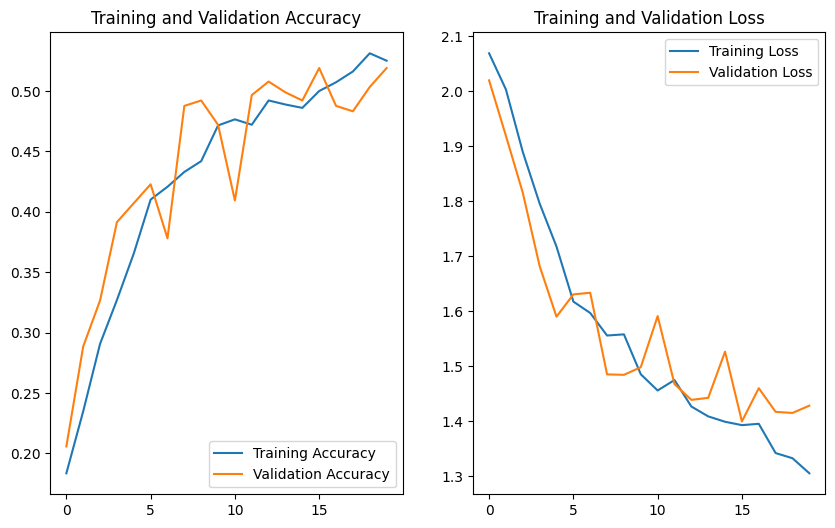

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Observation :**

**Insights from the Second Model**

acuracy graph:
- the training accuracy increases steadly and reaches upto 0.55.
- the validation accuracy fluctuating but follows upward, but still there is noticible gap between training and validation line this indactes overfitting toward end of training.


loss graph:
- both validation and traning descrease over time, that is model showing improvement than the first model.
- validation loss higher that training so it's showing some overfiting at the end.

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
## Your code goes here.

from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [24]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0025322.jpg', 'basal cell carcinoma'), ('/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0025700.jpg', 'basal cell carcinoma'), ('/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0024984.jpg', 'basal cell carcinoma'), ('/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0025630.jpg', 'basal cell carcinoma'), ('/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0025260.jpg', 'basal cell carcinoma')]


In [25]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/gdrive/My Drive/Melanoma Detection/Sk...,basal cell carcinoma
1,/content/gdrive/My Drive/Melanoma Detection/Sk...,basal cell carcinoma
2,/content/gdrive/My Drive/Melanoma Detection/Sk...,basal cell carcinoma
3,/content/gdrive/My Drive/Melanoma Detection/Sk...,basal cell carcinoma
4,/content/gdrive/My Drive/Melanoma Detection/Sk...,basal cell carcinoma


In [26]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


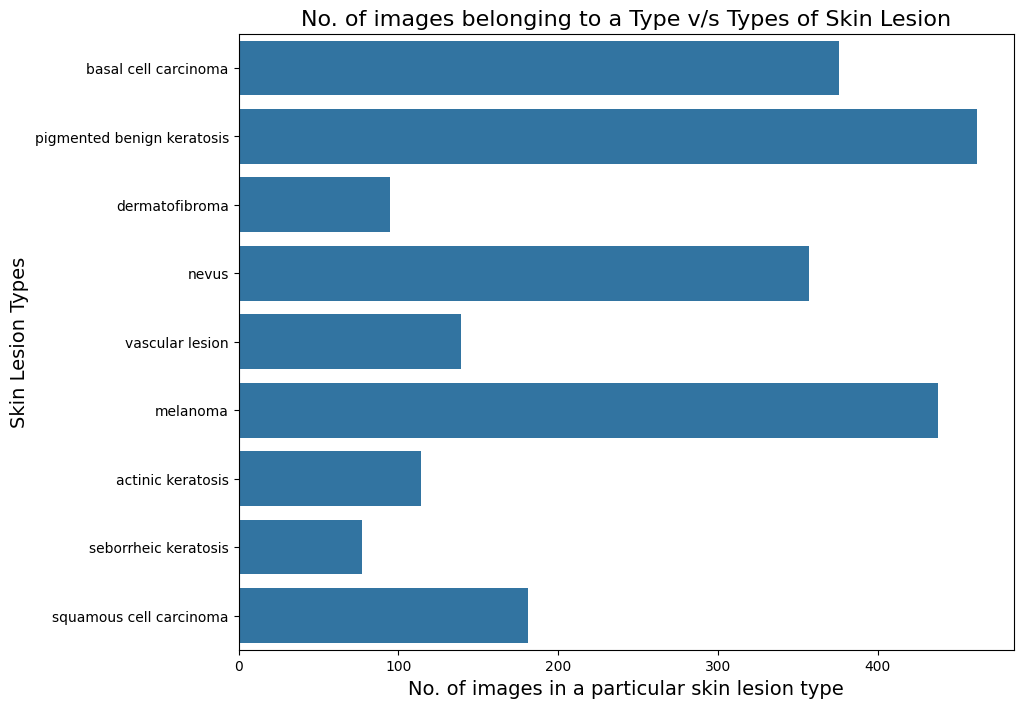

In [27]:
# Visualize the distribution of classes using a countplot

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [28]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2) #distribution of classes in percentage’s

,proportion
Label,
pigmented benign keratosis,20.63
melanoma,19.56
basal cell carcinoma,16.79
nevus,15.94
squamous cell carcinoma,8.08
vascular lesion,6.21
actinic keratosis,5.09
dermatofibroma,4.24
seborrheic keratosis,3.44


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
Ans: seborrheic keratosis has least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
Ans: pigmented benign keratosis data dominates in temrs of proportion and after that it is melanoma.

***Observations:***

1. A clear class imbalance is evident within the training data.

2. The class **"seborrheic keratosis"** comprises the smallest proportion of samples, accounting for approximately **3.41%**.

3. **"Pigmented benign keratosis"** and **"melanoma"** significantly outweigh other classes, representing approximately **20.80%** and **19.42%** of the data, respectively.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset= str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A47B09C13C0>: 100%|██████████| 500/500 [00:27<00:00, 18.06 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A47D69C0970>: 100%|██████████| 500/500 [00:18<00:00, 26.38 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A47D69C0580>: 100%|██████████| 500/500 [00:21<00:00, 23.67 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7A47D69DD000>: 100%|██████████| 500/500 [01:31<00:00,  5.45 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7A47B0AE4D60>: 100%|██████████| 500/500 [01:12<00:00,  6.91 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A47D6974070>: 100%|██████████| 500/500 [00:19<00:00, 26.11 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A47AF5A1600>: 100%|██████████| 500/500 [00:43<00:00, 11.45 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A47B0B47FD0>: 100%|██████████| 500/500 [00:20<00:00, 23.83 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A47B0B75390>: 100%|██████████| 500/500 [00:19<00:00, 25.40 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026230.jpg_0f3fe591-f148-4379-b821-b472fd00003e.jpg',
 '/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029263.jpg_73f7a9b6-af2e-482b-a2ba-3a421f3eaafb.jpg',
 '/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027478.jpg_bb0bc64a-02af-4b5f-b1b9-962623321803.jpg',
 '/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029391.jpg_cd9b5fa0-98bf-44c4-a45d-6aab9fca9503.jpg',
 '/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The Inter

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma']

In [34]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(6739, 3)

In [36]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


In [37]:
round(new_df[['Label']].value_counts(normalize=True)*100, 2) #distribution of classes in percentage’s

,proportion
Label,
pigmented benign keratosis,14.28
melanoma,13.92
basal cell carcinoma,13.00
nevus,12.72
squamous cell carcinoma,10.11
vascular lesion,9.48
actinic keratosis,9.11
dermatofibroma,8.83
seborrheic keratosis,8.56


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

In [39]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train1 = pathlib.Path("/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train")


In [40]:
#print the directory path
data_dir_train1

PosixPath('/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [41]:
# Count the number of JPEG images in the specified directory
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))

# Print the total count of JPEG images
print(image_count_train1)

2239


#### **Todo:** Create a training dataset

In [42]:
## Write your training dataset
# Define the directory path where the training data is located
data_dir_train1 = pathlib.Path("/content/gdrive/My Drive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123, #reproducibility of data shuffling
  validation_split=0.2, # validation_split
  subset="training", # training data
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [43]:
## Write your validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [44]:
## your code goes here

num_classes = 9 # Define the number of classes for the classification task
model = Sequential([ # Create a Sequential model
    layers.Rescaling(1./255, input_shape=(img_height, img_width,3)) # Rescale pixel values to the range [0,1]
])

# Add Convolutional layers with ReLU activation
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(180, 180, 32)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))  # Add MaxPooling to downsample the feature maps

# Add additional Convolutional layers with ReLU activation and MaxPooling
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25)) # Apply Dropout regularization to prevent overfitting
model.add(Flatten()) # Flatten the output from convolutional layers to feed into Dense layers
model.add(Dense(num_classes, activation="softmax")) # Add Dense (fully connected) layer with softmax activation for classification

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [45]:
## your code goes here
# Compiling the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [46]:
epochs = 50  # Set the number of training epochs to 50

## Your code goes here, use 50 epochs.

history = model.fit(
  train_ds, #training dataset
  validation_data=val_ds, #validation dataset
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 322ms/step - accuracy: 0.1595 - loss: 2.1615 - val_accuracy: 0.1811 - val_loss: 2.0895
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 70s 279ms/step - accuracy: 0.2444 - loss: 1.9702 - val_accuracy: 0.2799 - val_loss: 1.8293
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 266ms/step - accuracy: 0.3148 - loss: 1.7672 - val_accuracy: 0.3875 - val_loss: 1.6023
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 254ms/step - accuracy: 0.4299 - loss: 1.5298 - val_accuracy: 0.4922 - val_loss: 1.4190
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 266ms/step - accuracy: 0.5297 - loss: 1.3188 - val_accuracy: 0.4915 - val_loss: 1.4601
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 254ms/step - accuracy: 0.5969 - loss: 1.1370 - val_accuracy: 0.5516 - val_loss: 1.3366
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 267ms/step - accuracy: 0.6613 - loss: 0.9930 - val_accuracy: 0.6214 - val_loss: 1.2155
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 253ms/step - accuracy: 0.7483 - loss: 0.7302 - val

#### **Todo:**  Visualize the model results

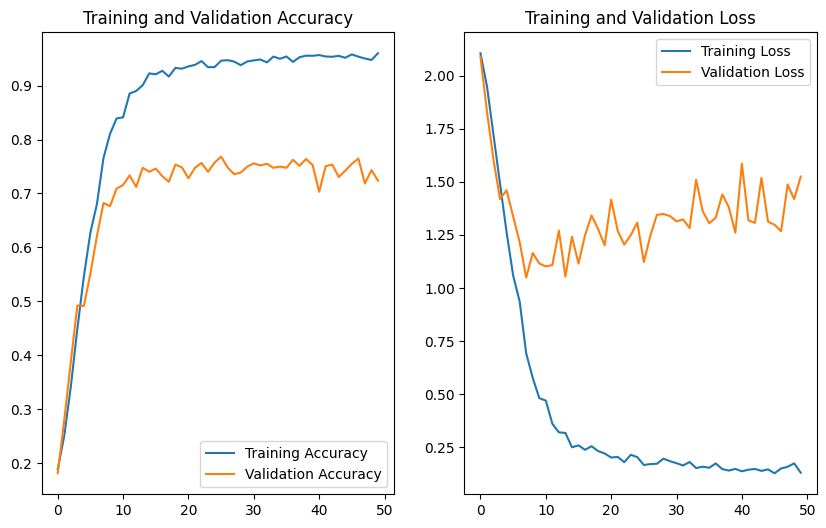

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- The model achives a high training accuracy approching 0.95 so it learn well on training data.
- The validation accuracy increases in the first few epochs it shows  model is learning useful patterns from the data.
- The training loss consistently decreasing is shows model minimizing errors on training data.
- The validation loss decreases at strating is shows model generalizes well on unseen data in easrly stage